In [13]:
import polars as pl
from polars import col as C
import plotnine as gg

In [14]:
INPUT_CSV = "output/1e8_pokemon.csv"

In [15]:
lf = pl.scan_csv(INPUT_CSV)

## Shinies

In [16]:
lf = lf.with_columns(
    C("shiny").eq("true")
)

In [17]:
count_shiny_df = lf.select("shiny").collect()
n_pokemon = count_shiny_df.height
shinies = count_shiny_df.filter(C("shiny")).height
shiny_rate = shinies / n_pokemon
inverse_shiny_rate = 1 / shiny_rate
print(f"Number of Pokemon: {n_pokemon}")
print(f"Number of shinies: {shinies}")
print(f"Shiny rate: 1/{inverse_shiny_rate:.2f}")

Number of Pokemon: 100000000
Number of shinies: 12169
Shiny rate: 1/8217.60


In [18]:
encounters_df = (
    lf
    .with_columns(
        C("shiny").cum_sum()
        .alias("shiny_id")
    )
    .filter(C("shiny_id").ne(pl.max("shiny_id")))
    .group_by("shiny_id")
    .agg(encounters=C("shiny_id").count())
    .collect()
)

In [19]:
encounters_df.sort("encounters").head(10)

shiny_id,encounters
u32,u32
408,2
2321,3
3545,4
4403,5
4883,7
2317,7
3801,7
4516,7
11234,8


In [20]:
encounters_df.sort("encounters").tail(10)

shiny_id,encounters
u32,u32
3416,54581
11664,57691
7024,58987
4129,60173
7326,60641
2021,60690
1958,62443
3099,62819
1969,66499


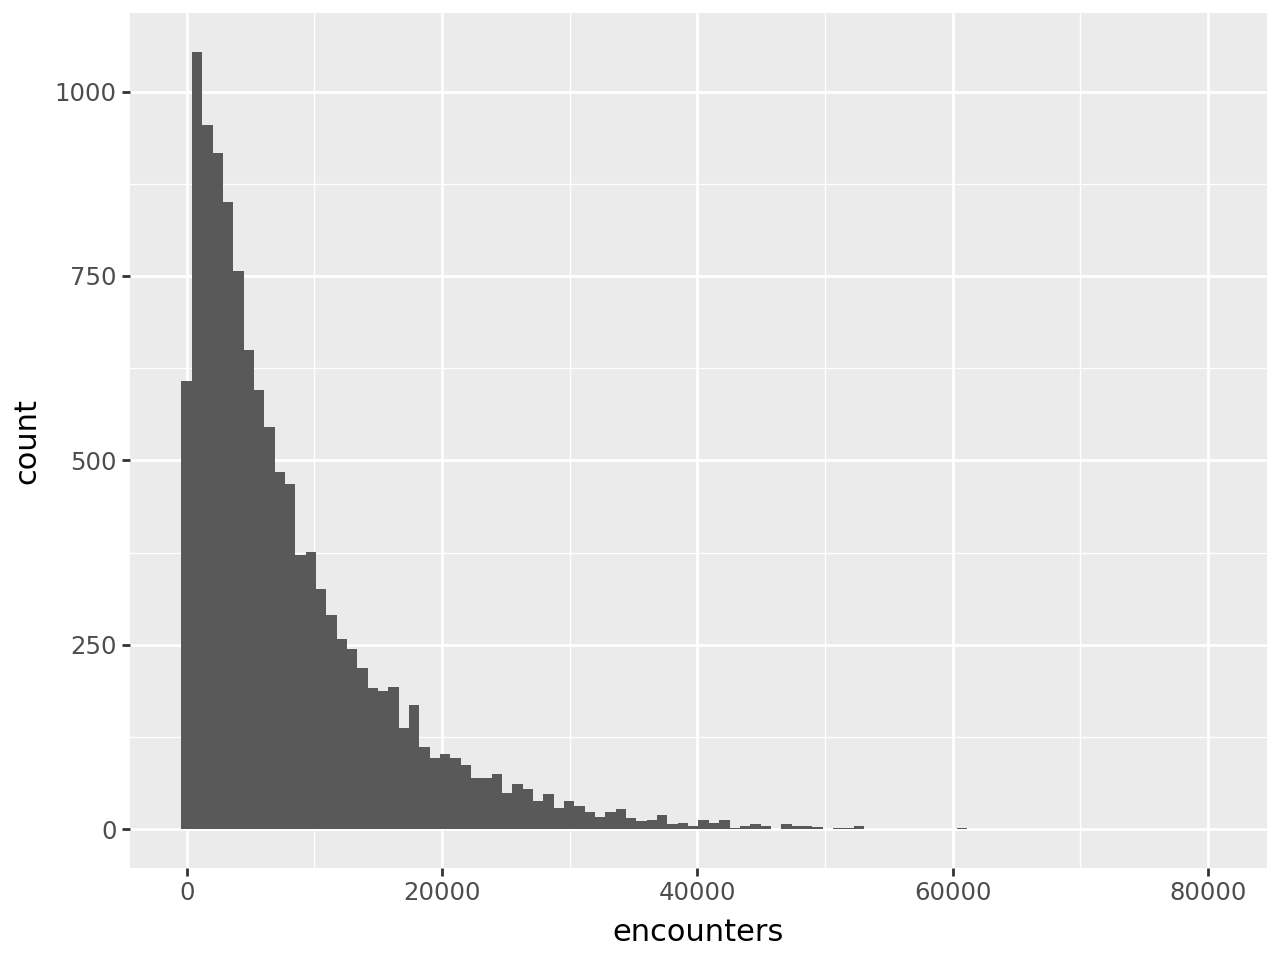

In [21]:
# histogram encounters
(
    gg.ggplot(encounters_df)
    + gg.aes(x="encounters")
    + gg.geom_histogram(bins=100)
)

## IVs

In [22]:
iv_cols = [col for col in lf.columns if col.endswith("_iv")]
lf = lf.with_columns(total_iv=pl.lit(0))
for col in iv_cols:
    lf = lf.with_columns(C("total_iv").add(C(col)))

iv_df = lf.select(iv_cols + ["total_iv"]).sort("total_iv", descending=True).collect()

In [23]:
print(iv_df.head(8))
print(iv_df.tail(8))

shape: (8, 7)
┌───────┬────────┬────────┬──────────┬──────────┬──────────┬──────────┐
│ hp_iv ┆ atk_iv ┆ def_iv ┆ spatk_iv ┆ spdef_iv ┆ speed_iv ┆ total_iv │
│ ---   ┆ ---    ┆ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ i64   ┆ i64    ┆ i64    ┆ i64      ┆ i64      ┆ i64      ┆ i64      │
╞═══════╪════════╪════════╪══════════╪══════════╪══════════╪══════════╡
│ 31    ┆ 31     ┆ 31     ┆ 31       ┆ 31       ┆ 31       ┆ 186      │
│ 30    ┆ 31     ┆ 30     ┆ 31       ┆ 31       ┆ 31       ┆ 184      │
│ 31    ┆ 30     ┆ 31     ┆ 31       ┆ 31       ┆ 30       ┆ 184      │
│ 31    ┆ 30     ┆ 31     ┆ 31       ┆ 31       ┆ 30       ┆ 184      │
│ 30    ┆ 31     ┆ 31     ┆ 31       ┆ 30       ┆ 31       ┆ 184      │
│ 30    ┆ 31     ┆ 29     ┆ 31       ┆ 31       ┆ 31       ┆ 183      │
│ 30    ┆ 30     ┆ 31     ┆ 30       ┆ 31       ┆ 31       ┆ 183      │
│ 28    ┆ 31     ┆ 31     ┆ 31       ┆ 31       ┆ 31       ┆ 183      │
└───────┴────────┴────────┴──────────┴──────────┴─

## Gender

In [24]:
(
    lf
    .group_by("gender")
    .agg(C("gender").count().alias("count"))
    .with_columns(
        share=C("count") / n_pokemon
    )
    .collect()
)

gender,count,share
str,u32,f64
"""Female""",49221869,0.492219
"""Male""",50778131,0.507781
